# Feature Selection and binning

### I think Information Value + lasso regression will be good for feature selection since the target is binary and already most of the columns are categorical, we will drop columns that have a very low IV + coefficient zeroed out


In [11]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from optbinning import OptimalBinning
import warnings
warnings.filterwarnings('ignore')

##### transform uknown smoking status into never smoked, since it had the closest distribution of storke vs no stroke, 

In [12]:
df = pd.read_csv('preprocessed_data.csv',index_col=0)

In [15]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5109 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5109 non-null   object 
 1   age                5109 non-null   float64
 2   hypertension       5109 non-null   int64  
 3   heart_disease      5109 non-null   int64  
 4   ever_married       5109 non-null   object 
 5   work_type          5109 non-null   object 
 6   Residence_type     5109 non-null   object 
 7   avg_glucose_level  5109 non-null   float64
 8   bmi                5109 non-null   float64
 9   smoking_status     5109 non-null   object 
 10  stroke             5109 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 479.0+ KB


### First we should split data and only fit the binning algorith on train and then transform train and test

In [17]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=101)

### WOE and IV

In [18]:

y_train = train_df["stroke"]
X_train = train_df.drop(columns=["stroke"])
X_test = test_df.copy()
y_test = test_df["stroke"]


binning_transformers = {}
X_train_binned = pd.DataFrame()
X_test_binned = pd.DataFrame()
X_train_binned_woe = pd.DataFrame()
X_test_binned_woe = pd.DataFrame()
iv_scores = {}
all_woe_rows = []


def is_binary(series):
    return set(series.dropna().unique()) <= {0, 1}


for column in X_train.columns:
    # Define variable type
    if is_binary(X_train[column]):
        dtype = "categorical"
    elif pd.api.types.is_numeric_dtype(X_train[column]):
        dtype = "numerical"
    else:
        dtype = "categorical"

    # Fit binning
    optb = OptimalBinning(name=column, dtype=dtype, solver="cp", max_n_bins=3)
    optb.fit(X_train[column], y_train)
    binning_transformers[column] = optb

    # Transform to WOE and bins
    X_train_binned_woe[column] = -optb.transform(X_train[column], metric="woe")
    X_test_binned_woe[column] = -optb.transform(X_test[column], metric="woe")
    X_train_binned[column] = optb.transform(X_train[column], metric="bins")
    X_test_binned[column] = optb.transform(X_test[column], metric="bins")

    # Build binning table and extract WOE info
    binning_table_df = optb.binning_table.build()
    iv_scores[column] = float(optb.binning_table.iv)

    # Add variable name and IV to each row, then store
    binning_table_df["Variable"] = column
    binning_table_df["IV"] = iv_scores[column]
    all_woe_rows.append(binning_table_df[["Variable", "Bin", "Count", "Event rate", "WoE", "IV"]])


all_woe_combined = pd.concat(all_woe_rows, ignore_index=True)


all_woe_combined.to_excel("woe_all_variables.xlsx", index=False)


print(all_woe_combined.head())

  Variable       Bin  Count  Event rate       WoE        IV
0   gender  [Female]   2380    0.046218  0.033376  0.001499
1   gender    [Male]   1707    0.049795 -0.044915  0.001499
2   gender   Special      0    0.000000       0.0  0.001499
3   gender   Missing      0    0.000000       0.0  0.001499
4   gender             4087    0.047712            0.001499


In [19]:
X_train_binned

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,['Female'],"[37.50, 67.50)",[0],[0],['Yes'],['Private' 'Govt_job'],['Urban'],"(-inf, 78.92)","[25.55, inf)",['never smoked']
1,['Female'],"[67.50, inf)",[0],[0],['Yes'],['Private' 'Govt_job'],['Urban'],"[78.92, 161.86)","[25.55, inf)",['formerly smoked']
2,['Female'],"[37.50, 67.50)",[0],[0],['Yes'],['Private' 'Govt_job'],['Rural'],"[78.92, 161.86)","[25.55, inf)",['never smoked']
3,['Female'],"[67.50, inf)",[0],[0],['Yes'],['Private' 'Govt_job'],['Urban'],"[78.92, 161.86)","[25.55, inf)",['never smoked']
4,['Male'],"[37.50, 67.50)",[1],[0],['Yes'],['Private' 'Govt_job'],['Rural'],"[161.86, inf)","[25.55, inf)",['never smoked']
...,...,...,...,...,...,...,...,...,...,...
4082,['Male'],"(-inf, 37.50)",[0],[0],['No'],['Never_worked' 'children'],['Urban'],"(-inf, 78.92)","(-inf, 19.35)",['never smoked']
4083,['Female'],"[37.50, 67.50)",[1],[0],['Yes'],['Private' 'Govt_job'],['Urban'],"[161.86, inf)","[25.55, inf)",['never smoked']
4084,['Female'],"[37.50, 67.50)",[0],[0],['Yes'],['Private' 'Govt_job'],['Urban'],"[78.92, 161.86)","[25.55, inf)",['never smoked']
4085,['Male'],"[37.50, 67.50)",[0],[1],['Yes'],['Self-employed'],['Rural'],"[161.86, inf)","[25.55, inf)",['never smoked']


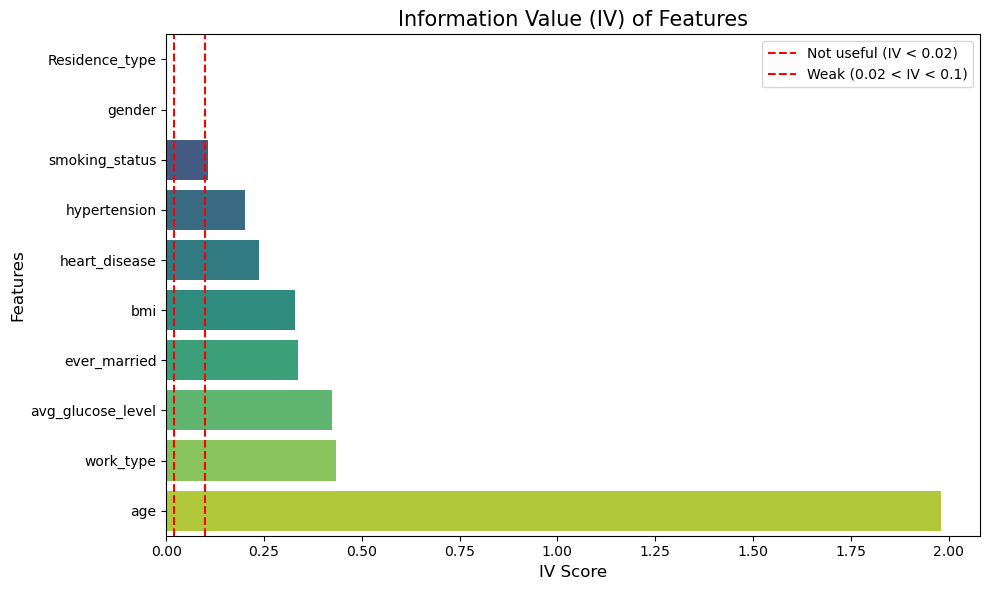

In [20]:
iv_df = pd.DataFrame.from_dict(iv_scores, orient='index', columns=['IV'])
iv_df.sort_values(by='IV', ascending=True, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(x='IV', y=iv_df.index, data=iv_df, palette='viridis')

plt.title('Information Value (IV) of Features', fontsize=15)
plt.xlabel('IV Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.axvline(x=0.02, color='red', linestyle='--', label='Not useful (IV < 0.02)')
plt.axvline(x=0.1, color='red', linestyle='--', label='Weak (0.02 < IV < 0.1)')

plt.legend()

plt.tight_layout()
plt.show()


Only columns above 0.1 will be used

In [21]:
no_prediction_power = [] # to be removed if lasso also 0
good_prediction_power = []

for key, value in iv_scores.items():
    if value <= 0.1:
        no_prediction_power += [key]
    else:
        good_prediction_power += [key]

In [22]:
good_prediction_power

['age',
 'hypertension',
 'heart_disease',
 'ever_married',
 'work_type',
 'avg_glucose_level',
 'bmi',
 'smoking_status']

##### Based on IV gender and residence type have no predictive power, age is suspciously high but considering we are predicting strokes it makes sense

### Lasso 

In [23]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

# Search for the optimal alpha using cross validation
lasso = LassoCV(
    alphas=np.logspace(-5, 0, 50),
    cv=5, random_state=42, max_iter=10_000)
lasso.fit(X_train_binned_woe, y_train)

LassoCV(alphas=array([1.00000000e-05, 1.26485522e-05, 1.59985872e-05, 2.02358965e-05,
       2.55954792e-05, 3.23745754e-05, 4.09491506e-05, 5.17947468e-05,
       6.55128557e-05, 8.28642773e-05, 1.04811313e-04, 1.32571137e-04,
       1.67683294e-04, 2.12095089e-04, 2.68269580e-04, 3.39322177e-04,
       4.29193426e-04, 5.42867544e-04, 6.86648845e-04, 8.68511374e-04,
       1.09854114e-03, 1.38949549e-0...
       7.19685673e-03, 9.10298178e-03, 1.15139540e-02, 1.45634848e-02,
       1.84206997e-02, 2.32995181e-02, 2.94705170e-02, 3.72759372e-02,
       4.71486636e-02, 5.96362332e-02, 7.54312006e-02, 9.54095476e-02,
       1.20679264e-01, 1.52641797e-01, 1.93069773e-01, 2.44205309e-01,
       3.08884360e-01, 3.90693994e-01, 4.94171336e-01, 6.25055193e-01,
       7.90604321e-01, 1.00000000e+00]),
        cv=5, max_iter=10000, random_state=42)

##### Get all columns where the coeficient is non zero

In [24]:
selected_lasso = X_train_binned_woe.columns[lasso.coef_ != 0].tolist()
print("Selected features by Lasso:")
print(*selected_lasso, sep='\n')


Selected features by Lasso:
age
hypertension
heart_disease
ever_married
work_type
avg_glucose_level
bmi
smoking_status


In [25]:
selected_lasso == good_prediction_power

True

### Both the lasso and IV method yielded the same columns as ones with good predictive power, it is sufficient evidence to keep them

In [26]:
train_df = train_df.drop(columns=no_prediction_power)
test_df = test_df.drop(columns=no_prediction_power)

In [27]:
X_train_binned_woe = X_train_binned_woe.drop(columns=no_prediction_power)
X_test_binned_woe = X_test_binned_woe.drop(columns=no_prediction_power)

In [28]:
X_train_binned = X_train_binned.drop(columns=no_prediction_power)
X_test_binned = X_test_binned.drop(columns=no_prediction_power)

In [29]:
X_train_binned_woe.head()

,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status
0,-0.118354,-0.196854,-0.169132,0.313932,0.017421,-0.172265,0.246091,-0.220279
1,1.406714,-0.196854,-0.169132,0.313932,0.017421,-0.464852,0.246091,0.578976
2,-0.118354,-0.196854,-0.169132,0.313932,0.017421,-0.464852,0.246091,-0.220279
3,1.406714,-0.196854,-0.169132,0.313932,0.017421,-0.464852,0.246091,-0.220279
4,-0.118354,1.044858,-0.169132,0.313932,0.017421,1.163205,0.246091,-0.220279


### Merge target with predictiors back togheter

In [30]:
X_train_binned_woe['stroke'] = y_train.values
X_test_binned_woe['stroke'] = y_test.values

In [31]:
train_df_woe = X_train_binned_woe
test_df_woe = X_test_binned_woe

### Save as df ready for building models

In [32]:
train_df_woe.to_csv('train_df_woe.csv')
test_df_woe.to_csv('test_df_woe.csv')

In [33]:
X_train_binned.to_csv('train_bins.csv')
X_test_binned.to_csv('test_bins.csv')

In [34]:
train_df.to_csv('train_df.csv')
test_df.to_csv('test_df.csv')